In [1]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
from paramets import *
import numpy as np
from tqdm import tqdm

## Rewrite the original code using torch

In [2]:
# Ng, Tf = 64, 10001

def laplacian_1d(n):
    # Total number of grid points
    total_points = n
    # Initialize a lil_matrix with shape (N, N)
    matrix_laplacian = lil_matrix((total_points, total_points))
    # Fill in the matrix
    for i in range(n):
        matrix_laplacian[i, i] = -2.0
        if i > 0:
            matrix_laplacian[i, i-1] = 1.0
        if i < n - 1:
            matrix_laplacian[i, i+1] = 1.0

    # Convert to CSR format for efficient arithmetic operations
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
                torch.tensor([row_indices, col_indices], dtype=torch.int64),
                torch.tensor(values, dtype=torch.float32),
                torch.Size((n,n))
                )

    return coo_matrix

# Example usage
grid_size = 4  # Change this value to adjust the grid size
laplacian_matrix = laplacian_1d(grid_size)

print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[ 2., -1.,  0.,  0.],
        [-1.,  2., -1.,  0.],
        [ 0., -1.,  2., -1.],
        [ 0.,  0., -1.,  2.]])


In [3]:
master_list = []
def integrate(L, u, T):
    '''  simulates the equation and plots it at different instants '''
    dx = 0.316
    T = torch.tensor([T], device='cpu')
    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng, 1), device='cpu')
        u[0] = -1 
        u[Ng-1] = +1
        u = u + (dt/dx**2) * torch.mm(L, u) - dt * 2 * u * (u**2 - 1) \
            + torch.sqrt(2 * T * dt) * noise   # Euler's method
        if (i==10000):
            master_list.append(u)

## Calculate the mean of configurations

In [6]:
def avg_realizations(master_list, Ng):
    """ Evaluate the average over the configurations (realizations)"""
    mean_config = []
    size = len(master_list)
    N = Ng
    temp = 0
    for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
        for config in range(size):
            temp += master_list[config][point]
        mean_config.append(temp/size)
        temp = 0
    mean_config = torch.tensor(mean_config)
    mean_config = mean_config.view((Ng))
    #plt.figure(figsize=(4, 3))
    #plt.imshow(mean_config)
    #plt.show()
    return mean_config

In [13]:
def avg_final(mean_config, Ng):
    sum = 0 
    for x in range(Ng):
        for y in range(Ng):
            sum = sum + mean_config[x][y]
    return sum / (Ng*Ng)

# media_final(mean_config, Ng)

## RUN PIPELINE

In [4]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais
L = laplacian_1d(Ng)
L = L.to(device)         # construct the laplacian
N_real = 100

list_vev = []

c:\Users\mille\Documents\CloneGit\ising-models\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
list_mean_config = []
for T in [0.0001]: #np.linspace(0.01, 15, num=10):
  T = float(T)
  print(f"---------------- Temperature: {T} --------------------- ")
  for realization in tqdm(range(N_real), desc="Processing", ncols=100, ascii=True):
    u = torch.randn(Ng, 1, device=device)  # Initial data
    ## boundary_cond
    u[0] = -1 
    u[Ng-1] = +1
    integrate(L, u, T)    # simulate

  mean_config = avg_realizations(master_list, Ng)
  list_mean_config.append(mean_config)

---------------- Temperature: 0.0001 --------------------- 


Processing: 100%|##################################################| 64/64 [00:00<00:00, 551.38it/s]


In [8]:
list_mean = list_mean_config[0].tolist()
list_x = [x for x in range(Ng)]

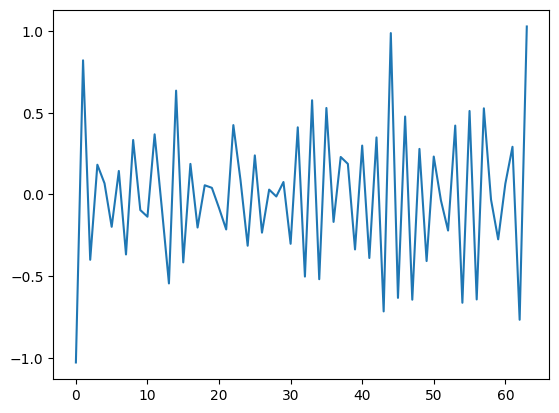

In [9]:
plt.plot(list_x, list_mean)
plt.show()

In [5]:
mat1 = torch.randn(2, 3)
mat2 = torch.randn(3, 3)

In [7]:
mat1

tensor([[ 0.2822,  2.0878,  1.9945],
        [ 0.9539, -0.8214, -0.9259]])

In [8]:
mat2

tensor([[-1.2273,  0.8013,  0.7207],
        [-0.8434, -1.8725, -1.5339],
        [-0.7285, -0.6873,  0.1146]])

In [6]:
torch.mm(mat1, mat2)

tensor([[-3.5601, -5.0540, -2.7706],
        [ 0.1966,  2.9387,  1.8413]])